In [236]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly
from scipy.spatial.transform import Rotation


M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [237]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Index')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Index')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def importfitting(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    len(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        data = np.load(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return locpred, anglepred, Bstdev

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

In [251]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX06062024_10mmAboveIsocenter"
locpred, anglepred, Bstdev = importfitting(folder)
np.append(locpred, anglepred)

array([ 0.24061964, -0.20153245, 19.13513984,  0.22653218,  0.25373886,
       19.12557569,  0.20923906,  0.66420532, 19.13065875,  0.20060534,
        1.09719166, 19.1525272 ,  0.18055564,  1.53260663, 19.19138648,
       -0.17245637, -0.2073003 , 19.14892157, -0.19083967,  0.23131545,
       19.13607503, -0.20363791,  0.65870913, 19.14372627, -0.21522059,
        1.09546012, 19.16488527, -0.23815029,  1.53006652, 19.20270966,
       -0.58817587, -0.20370524, 19.17336857, -0.6100041 ,  0.25633094,
       19.16274916, -0.61261087,  0.6588494 , 19.16864993, -0.62597495,
        1.09648339, 19.19235567, -0.64713097,  1.53042941, 19.23033815,
       -0.99826487, -0.19219401, 19.21237165, -1.01966709,  0.2704488 ,
       19.20371208, -1.03310526,  0.6816701 , 19.21158462, -1.05656898,
        1.12965793, 19.23589043, -1.0428315 ,  1.52964233, 19.27366491,
       -1.42504908, -0.18035718, 19.26814932, -1.43106749,  0.24894255,
       19.25723785, -1.44606733,  0.69789441, 19.2615293 , -1.45

In [239]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX06062024_10mmAboveIsocenter"
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

In [240]:
loc_pred = [np.array([0,0,0])]
angle_pred = [np.array([0,0,0])]
B_stdev = [np.array(pos)]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
    x_res = minimize(x0, B, pos, M0, shape)
    loc_pred = np.append(loc_pred, [x_res[0:3]], axis=0)
    angle_pred = np.append(angle_pred, [x_res[3:6]], axis=0)
    B_stdev = np.append(B_stdev, [mags_stdev], axis=0)
loc_pred = np.delete(loc_pred, 0, axis=0)
angle_pred = np.delete(angle_pred, 0, axis=0)
B_stdev = np.delete(B_stdev, 0 ,axis=0)

In [241]:
np.append(loc_pred, angle_pred, axis=1)
#np.sum(angle_pred**2)

array([[ 0.24061964, -0.20153245, 19.13513984, -0.18092188,  0.18759216,
         0.96544107],
       [ 0.22653218,  0.25373886, 19.12557569, -0.18152782,  0.16669843,
         0.9691539 ],
       [ 0.20923906,  0.66420532, 19.13065875, -0.18261994,  0.14618011,
         0.9722558 ],
       [ 0.20060534,  1.09719166, 19.1525272 , -0.18207608,  0.12412856,
         0.97541873],
       [ 0.18055564,  1.53260663, 19.19138648, -0.18263531,  0.10046889,
         0.97803392],
       [-0.17245637, -0.2073003 , 19.14892157, -0.15812468,  0.19162368,
         0.96864697],
       [-0.19083967,  0.23131545, 19.13607503, -0.1591291 ,  0.17075069,
         0.97237962],
       [-0.20363791,  0.65870913, 19.14372627, -0.15917527,  0.14916465,
         0.97591657],
       [-0.21522059,  1.09546012, 19.16488527, -0.15867282,  0.12835296,
         0.97895273],
       [-0.23815029,  1.53006652, 19.20270966, -0.15930098,  0.10583365,
         0.98154085],
       [-0.58817587, -0.20370524, 19.17336857, -0.

In [242]:
def constfunc(const):
    actang = [np.array([0, 0, 0])]
    for y in range(5):
        for x in range(5):
            R = Rotation.from_euler('ZYX' ,np.array([0, 2*y-4, 2*x-4])-const, degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            actang = np.append(actang, [rotated], axis=0)
    actang = np.delete(actang, 0, axis=0)
    cost = np.sum((angle_pred-actang)**2)
    return cost

res= sp.optimize.minimize(constfunc, x0=np.array([0,0,0]))
shift = res.x
print(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.013080297887346314
        x: [-5.637e+00  6.901e+00  9.490e+00]
      nit: 27
      jac: [-5.502e-07 -2.580e-06 -2.640e-06]
 hess_inv: [[ 1.590e+04  2.585e+03 -1.965e+03]
            [ 2.585e+03  4.837e+02 -3.187e+02]
            [-1.965e+03 -3.187e+02  3.064e+02]]
     nfev: 124
     njev: 31


In [243]:
actang = [np.array([0, 0, 0])]
const = shift
for y in range(5):
    for x in range(5):
        R = Rotation.from_euler('ZYX' ,np.array([0, 2*y-4, 2*x-4])-const, degrees=True)
        norm = np.array([[0, 0, 1]])
        rotated = R.apply(norm, inverse=False)[0]
        #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
        actang = np.append(actang, [rotated], axis=0)
actang = np.delete(actang, 0, axis=0)
locact = actang*12
np.sum(actang**2)
print(actang)


[[-0.20591974  0.21408932  0.95486272]
 [-0.20399292  0.1800352   0.96227554]
 [-0.20181756  0.14576173  0.96851597]
 [-0.19939632  0.11131067  0.97357642]
 [-0.19673215  0.07672399  0.97745071]
 [-0.1726452   0.21737374  0.96069886]
 [-0.17046006  0.18334512  0.96815698]
 [-0.16806724  0.14909311  0.97443555]
 [-0.16546965  0.11465946  0.97952693]
 [-0.16267047  0.08008611  0.9834249 ]
 [-0.13918823  0.22067617  0.96536452]
 [-0.13674335  0.18667318  0.97285887]
 [-0.13413188  0.15244276  0.97916794]
 [-0.13135698  0.11802661  0.98428404]
 [-0.12842205  0.08346666  0.98820094]
 [-0.10558959  0.22399258  0.96885404]
 [-0.10288389  0.19001534  0.97637548]
 [-0.10005283  0.15580659  0.98270735]
 [-0.09709987  0.12140802  0.98784194]
 [-0.09402862  0.08686152  0.99177301]
 [-0.07189024  0.22731894  0.97116317]
 [-0.06892291  0.19336752  0.97870253]
 [-0.06587162  0.15918051  0.98504949]
 [-0.06274007  0.12479956  0.99019632]
 [-0.05953208  0.09026657  0.99413675]]


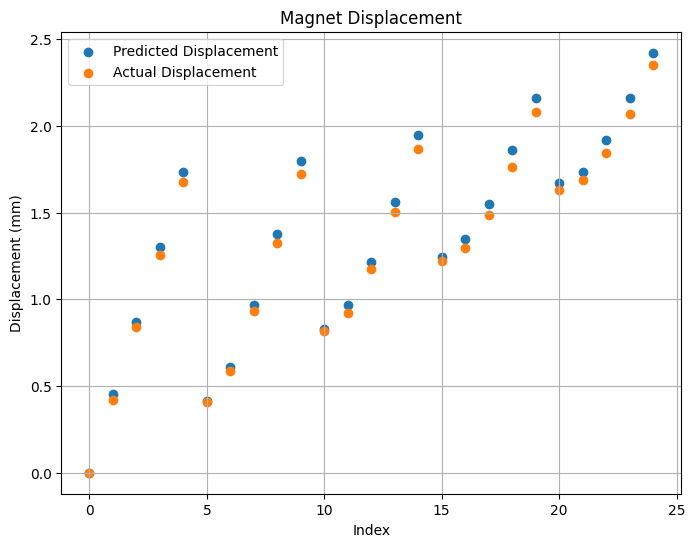

[ 0.         -0.01408746 -0.03138058 -0.04001429 -0.060064   -0.413076
 -0.4314593  -0.44425755 -0.45584023 -0.47876992 -0.82879551 -0.85062373
 -0.85323051 -0.86659459 -0.88775061 -1.23888451 -1.26028673 -1.2737249
 -1.29718862 -1.28345113 -1.66566871 -1.67168713 -1.68668697 -1.69204119
 -1.69082344]
[ 0.          0.45527131  0.86573777  1.29872411  1.73413909 -0.00576785
  0.43284791  0.86024158  1.29699257  1.73159897 -0.00217279  0.45786339
  0.86038185  1.29801585  1.73196186  0.00933845  0.47198126  0.88320255
  1.33119038  1.73117478  0.02117527  0.450475    0.89942686  1.33270115
  1.72242458]
[ 0.         -0.00956415 -0.00448109  0.01738736  0.05624664  0.01378173
  0.00093519  0.00858643  0.02974543  0.06756982  0.03822873  0.02760932
  0.03351009  0.05721583  0.09519831  0.07723181  0.06857223  0.07644478
  0.10075059  0.13852507  0.13300947  0.12209801  0.12638946  0.15274434
  0.19075368]
[0.         0.45558962 0.8663179  1.29945672 1.73609036 0.41334609
 0.61115899 0.9682

In [244]:
dispx = np.array(loc_pred[:,0]-loc_pred[:,0][0])
dispy = np.array(loc_pred[:,1]-loc_pred[:,1][0])
dispz = np.array(loc_pred[:,2]-loc_pred[:,2][0])
disp = np.sqrt(dispx**2+dispy**2+dispz**2)
actdispx = np.array(locact[:,0]-locact[:,0][0])
actdispy = np.array(locact[:,1]-locact[:,1][0])
actdispz = np.array(locact[:,2]-locact[:,2][0])
actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
plt.xlabel('Index')
plt.ylabel('Displacement (mm)')
plt.title('Magnet Displacement')
plt.legend()
plt.grid(True)
plt.show()

print(dispx)
print(dispy)
print(dispz)
print(disp)

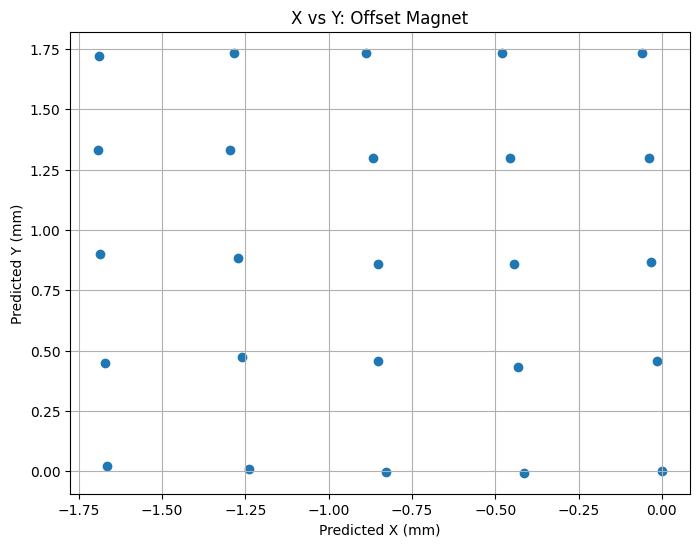

In [245]:
plt.figure(figsize=(8, 6))
plt.scatter(dispx, dispy, label='Predicted Location')
plt.xlabel('Predicted X (mm)')
plt.ylabel('Predicted Y (mm)')
plt.title('X vs Y: Offset Magnet')
#plt.legend()
plt.grid(True)
plt.show()

In [246]:
x1, z1 = loc_pred[5,0], loc_pred[5,2]
x2, z2 = loc_pred[10,0], loc_pred[10,2]
x3, z3 = loc_pred[15,0], loc_pred[15,2]
print("Radius of the circle about the x-axis:", circle_radius(x1, z1, x2, z2, x3, z3))

y1, z21 = loc_pred[0,1], loc_pred[0,2]
y2, z22 = loc_pred[1,1], loc_pred[1,2]
y3, z23 = loc_pred[2,1], loc_pred[2,2]
print("Radius of the circle about the y-axis:", circle_radius(y1, z21, y2, z22, y3, z23))

Radius of the circle about the x-axis: 11.478831577250016
Radius of the circle about the y-axis: 12.967584056397865


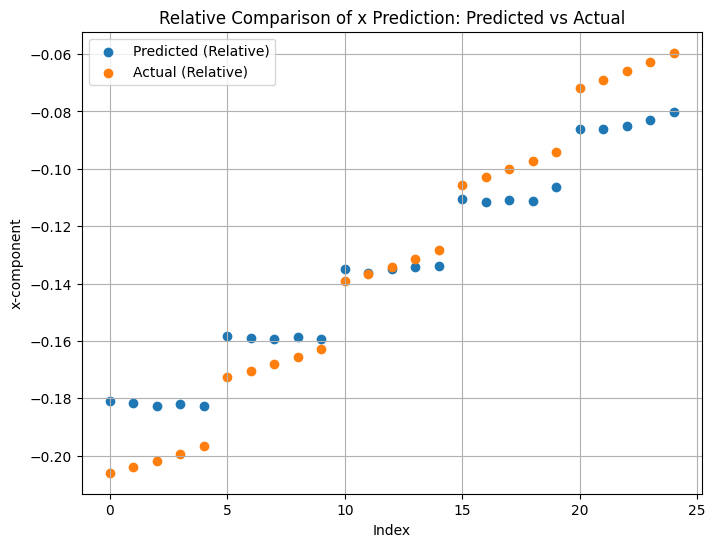

In [247]:
rel_locactx = [x-locact[0,0] for x in locact[:,0]]
rel_loc_predx = [x - loc_pred[0,0] for x in loc_pred[:,0]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(angle_pred[:,0]))), angle_pred[:,0], label='Predicted (Relative)')
plt.scatter(list(range(len(actang[:,0]))), actang[:,0], label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('x-component')
plt.title('Relative Comparison of x Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

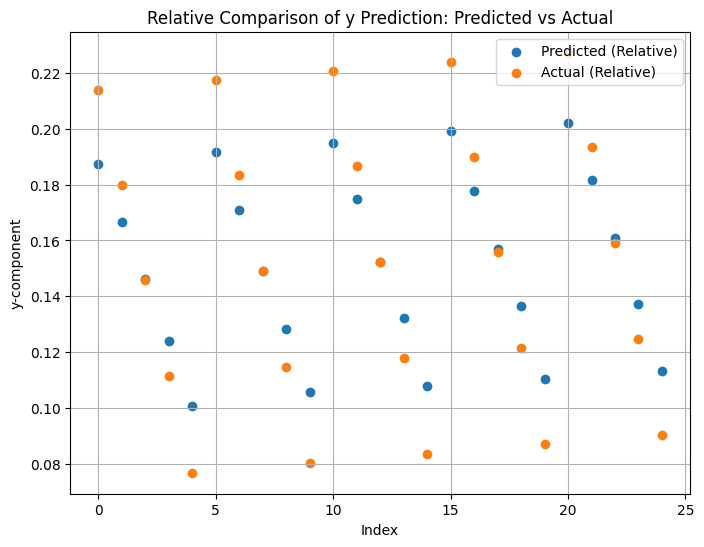

In [248]:
rel_locacty = [x-locact[0,1] for x in locact[:,1]]
rel_loc_predy = [x - loc_pred[0,1] for x in loc_pred[:,1]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(angle_pred[:,1]))), angle_pred[:,1], label='Predicted (Relative)')
plt.scatter(list(range(len(actang[:,1]))), actang[:,1], label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('y-component')
plt.title('Relative Comparison of y Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

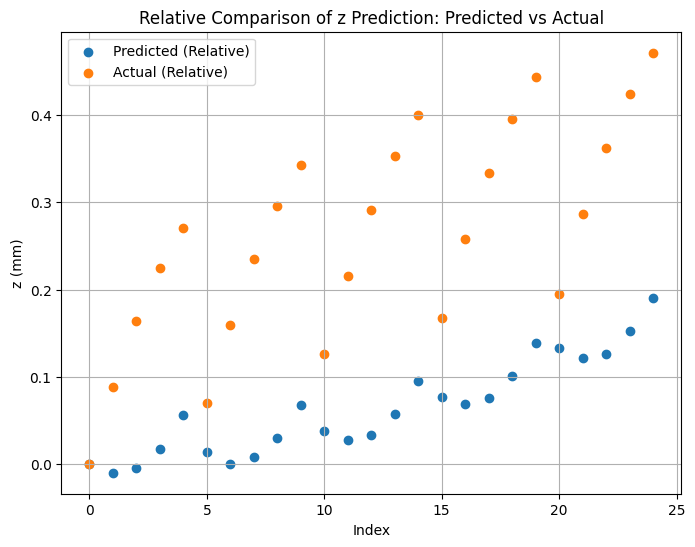

In [249]:
rel_locactz = [x-locact[0,2] for x in locact[:,2]]
rel_loc_predz = [x - loc_pred[0,2] for x in loc_pred[:,2]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predz))), rel_loc_predz, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_locactz))), rel_locactz, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('z (mm)')
plt.title('Relative Comparison of z Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

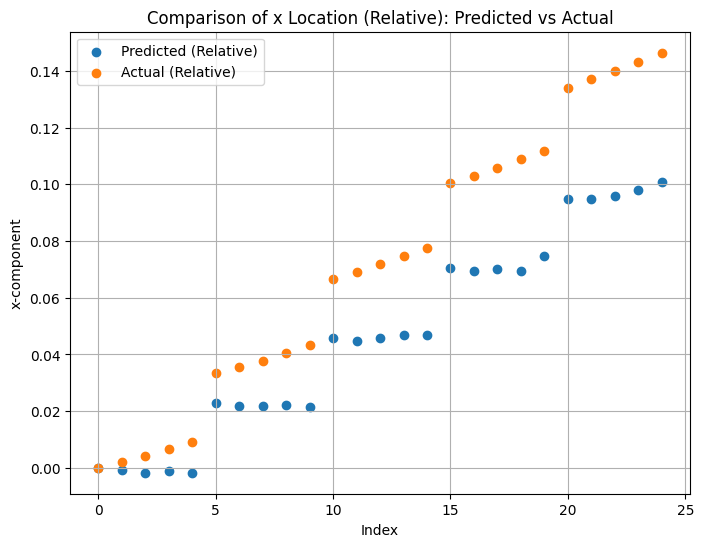

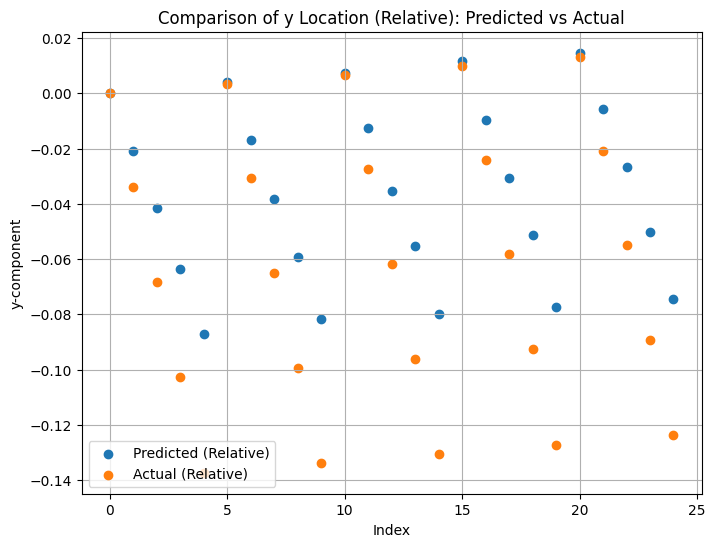

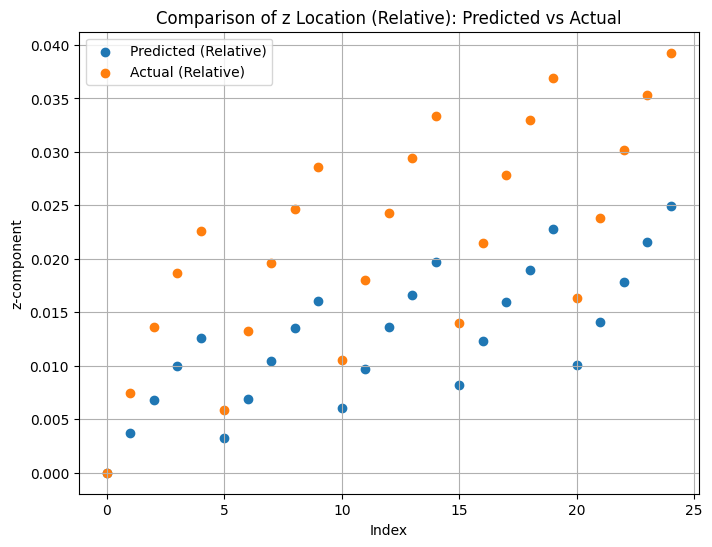

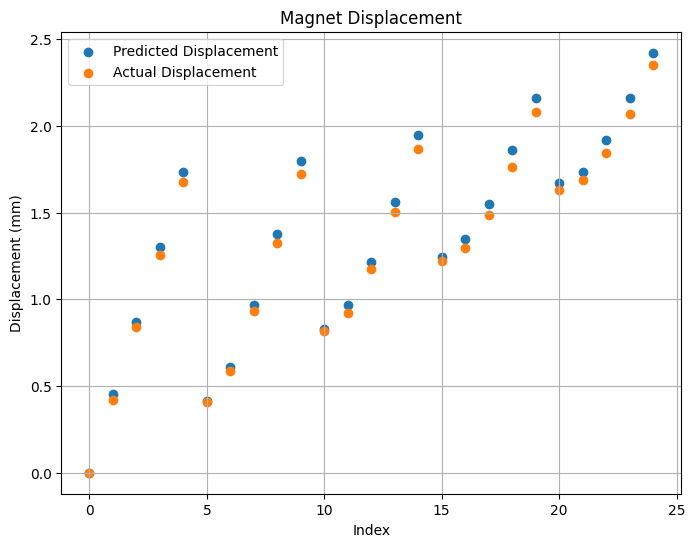

In [252]:
comparison_plot(actang, anglepred, axis='x', relative=True)
comparison_plot(actang, anglepred, axis='y', relative=True)
comparison_plot(actang, anglepred, axis='z', relative=True)
displacement_plot(locact, locpred)